# Importing Libraries

First we import the libraries necessary to analyze the data


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import utils as m

In [27]:
#load the cleaned data

incidents = pd.read_csv("../data/incidents_cleaned.csv", low_memory=False)
poverty = pd.read_csv("../data/poverty_cleaned.csv", low_memory=False)
districts = pd.read_csv("../data/districts_cleaned.csv", low_memory=False)

# and load our external data
population = pd.read_csv("../data/population_cleaned.csv", low_memory=False)

We decide to drop the following columns, as they are not useful for our analysis, or they contain too many missing values:
- **participant_age1, participant_age_group1, participant_gender1**: not reliable, as it's randomly picked and often matches the only participant
- **state_house_district, state_senate_district**: not useful
- **address**: too many missing values, often not standardized

In [28]:
incidents = incidents.drop(
    columns=['participant_age1', 'participant_age_group1', 'participant_gender1', 'state_house_district',
             'state_senate_district', 'address'])
incidents.info()
incidents.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183654 entries, 0 to 183653
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       183654 non-null  object 
 1   state                      183654 non-null  object 
 2   city_or_county             183654 non-null  object 
 3   latitude                   183654 non-null  float64
 4   longitude                  183654 non-null  float64
 5   congressional_district     180373 non-null  float64
 6   min_age_participants       140637 non-null  float64
 7   avg_age_participants       140633 non-null  float64
 8   max_age_participants       140634 non-null  float64
 9   n_participants_child       167019 non-null  float64
 10  n_participants_teen        167019 non-null  float64
 11  n_participants_adult       167019 non-null  float64
 12  n_males                    172462 non-null  float64
 13  n_females                  17

,date,state,city_or_county,latitude,longitude,congressional_district,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,...,n_injured,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,year,month,day
0,2015-05-02,Indiana,Indianapolis,39.8322,-86.2492,7.0,19.0,19.0,19.0,0.0,...,1,0,0,1,teen wounded while walking - security guard at...,shot - wounded/injured,NaN,2015,5,2
1,2017-04-03,Pennsylvania,Kane,41.6645,-78.7856,5.0,62.0,62.0,62.0,0.0,...,0,0,0,1,shot self after accident,"shot - dead (murder, accidental, suicide)",suicide^,2017,4,3
2,2016-11-05,Michigan,Detroit,42.4190,-83.0393,14.0,NaN,NaN,NaN,NaN,...,1,0,1,2,1 inj.,shot - wounded/injured,NaN,2016,11,5
3,2016-10-15,District of Columbia,Washington,38.9030,-76.9820,1.0,NaN,NaN,NaN,0.0,...,1,0,0,2,NaN,shot - wounded/injured,NaN,2016,10,15
4,2014-01-18,North Carolina,Wayne County,35.1847,-77.9527,13.0,65.0,65.0,65.0,0.0,...,1,0,0,1,NaN,shot - wounded/injured,home invasion,2014,1,18


There are still over than 40000 missing values for the age columns, since replacing them with the overall mean or median would spike the distribution too much, we try to smooth over the states.

In [29]:
# evaluate how to handle the missing values for min_age_participants, max_age_participants and avg_age_participants
# try by replacing with the mean of the state
age_columns = ['min_age_participants', 'max_age_participants', 'avg_age_participants']
mean_test = incidents.copy()
for column in age_columns:
    mean_by_state = mean_test.groupby('state')[column].mean()
    mean_test[column] = mean_test.apply(
        lambda row: mean_by_state[row['state']] if pd.isnull(row[column]) else row[column],
        axis=1
    )

# try by replacing with the median of the state
median_test = incidents.copy()
for column in age_columns:
    median_by_state = median_test.groupby('state')[column].median()
    median_test[column] = median_test.apply(
        lambda row: median_by_state[row['state']] if pd.isnull(row[column]) else row[column],
        axis=1
    )


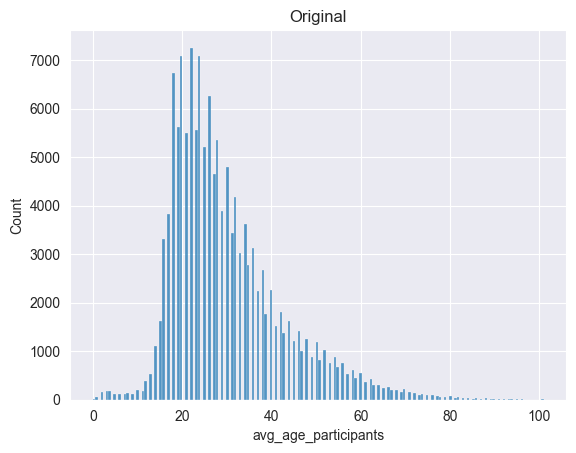

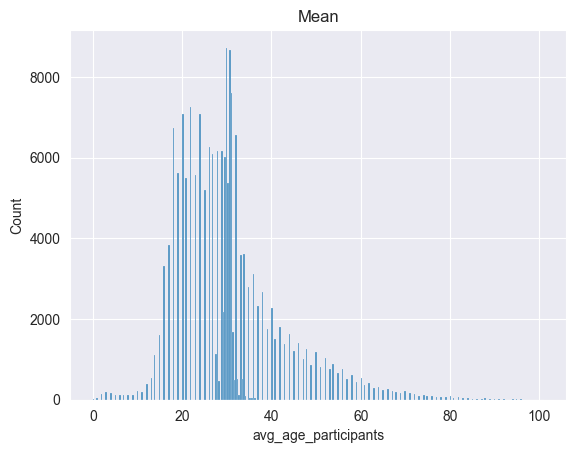

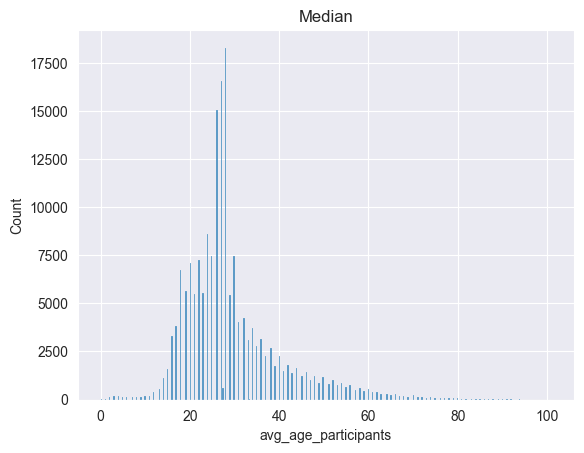

In [30]:
# plot the distributions of the original, mean and median values    
#fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=incidents, x='avg_age_participants')
plt.title('Original')
plt.show()
sns.histplot(data=mean_test, x='avg_age_participants')
plt.title('Mean')
plt.show()
sns.histplot(data=median_test, x='avg_age_participants')
plt.title('Median')
plt.show()

In [31]:
incidents[age_columns].describe()

,min_age_participants,max_age_participants,avg_age_participants
count,140637.000000,140634.000000,140633.000000
mean,28.359230,31.767147,29.994745
std,12.497303,13.693886,12.460197
min,0.000000,0.000000,0.000000
25%,20.000000,22.000000,21.000000
50%,25.000000,28.000000,27.000000
75%,34.000000,38.000000,36.000000
max,101.000000,101.000000,101.000000


In [32]:
mean_test[age_columns].describe()

,min_age_participants,max_age_participants,avg_age_participants
count,183654.000000,183654.000000,183654.000000
mean,28.407685,31.855919,30.062779
std,10.950676,12.008662,10.923276
min,0.000000,0.000000,0.000000
25%,21.000000,24.000000,23.000000
50%,27.835621,31.174792,29.463642
75%,31.000000,35.000000,33.000000
max,101.000000,101.000000,101.000000


In [33]:
median_test[age_columns].describe()

,min_age_participants,max_age_participants,avg_age_participants
count,183654.000000,183654.000000,183654.000000
mean,27.660356,31.054437,29.349004
std,11.023920,12.078705,10.988406
min,0.000000,0.000000,0.000000
25%,21.000000,24.000000,23.000000
50%,25.000000,29.000000,27.000000
75%,30.000000,35.000000,32.000000
max,101.000000,101.000000,101.000000


In [34]:
# we opt to use the median values
incidents = median_test
del mean_test
del median_test

We now try to handle the incident characteristics columns, which contains a lot of different values and nulls, and we try to group them into categories.

In [35]:
incidents['incident_characteristics1'].unique()

value_counts = incidents['incident_characteristics1'].value_counts(dropna=False)
print(value_counts)

incident_characteristics1
shot - wounded/injured                                                                                  80285
shot - dead (murder, accidental, suicide)                                                               40183
non-shooting incident                                                                                   32472
shots fired - no injuries                                                                               17554
armed robbery with injury/death and/or evidence of dgu found                                             3337
institution/group/business                                                                               3215
possession (gun(s) found during commission of other crimes)                                               990
brandishing/flourishing/open carry/lost/found                                                             925
drug involvement                                                                              

In [36]:
# Define the categories including missing incident characteristics
category_mapping = {
    'Deadly Shootings': [
        'shot - dead (murder, accidental, suicide)',
        'mass shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)',
        'officer involved incident', 'murder/suicide', 'animal shot/killed', 'suicide^',
        'spree shooting (multiple victims, multiple locations)'
    ],
    'Non-Deadly Shootings': [
        'shot - wounded/injured', 'accidental shooting', 'drive-by (car to street, car to car)',
        'spree shooting (multiple victims, multiple locations)'
    ],
    'Shots Fired, no casualties': [
        'shots fired - no injuries', 'shots fired, no action (reported, no evidence found)'
    ],
    'School related incident': [
        'school incident', 'gun at school, no death/injury - elementary/secondary school'
    ],
    'Drug related' : [
        'drug involvement',
        'under the influence of alcohol or drugs (only applies to the subject/suspect/perpetrator )'
    ],
    'Property Crime Related to Guns': [
        'armed robbery with injury/death and/or evidence of dgu found', 'gun shop robbery or burglary',
        'criminal act with stolen gun', 'gun range/gun shop/gun show shooting', 'gun(s) stolen from owner',
        'guns stolen from law enforcement'
    ],
    'Other Gun-Related Crimes': [
        'brandishing/flourishing/open carry/lost/found',
        'possession (gun(s) found during commission of other crimes)', 'atf/le confiscation/raid/arrest',
        'child involved incident', 'unlawful purchase/sale',
        'sex crime involving firearm'
    ],
    'Other Incidents': [
        'non-shooting incident', 'institution/group/business',  'home invasion',
        'domestic violence', 'gang involvement', 'kidnapping/abductions/hostage', 'pistol-whipping',
        'possession of gun by felon or prohibited person',
        'tsa action',
        'bar/club incident - in or around establishment',
        'attempted murder/suicide (one variable unsuccessful)', 'hate crime',
        'house party', 'shotspotter',
        'lockdown/alert only: no gv incident occurred onsite',
        'stolen/illegally owned gun{s} recovered during arrest/warrant'
    ],
    # 'Unspecified or Miscellaneous Incidents' category includes NaN values
    'Unspecified or Miscellaneous Incidents': [np.nan]
}


# Function to map incident characteristics to category indices
def map_to_category(characteristic):
    for category, characteristics in category_mapping.items():
        if pd.isna(characteristic) and pd.isna(characteristics[0]):
            return category
        elif characteristic in characteristics:
            return category
    return 'Unspecified or Miscellaneous Incidents'

# Apply the mapping function to create a new column 'category_index'
incidents['incident_category'] = incidents['incident_characteristics1'].apply(map_to_category)
incidents.head()

,date,state,city_or_county,latitude,longitude,congressional_district,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,...,n_arrested,n_unharmed,n_participants,notes,incident_characteristics1,incident_characteristics2,year,month,day,incident_category
0,2015-05-02,Indiana,Indianapolis,39.8322,-86.2492,7.0,19.0,19.0,19.0,0.0,...,0,0,1,teen wounded while walking - security guard at...,shot - wounded/injured,NaN,2015,5,2,Non-Deadly Shootings
1,2017-04-03,Pennsylvania,Kane,41.6645,-78.7856,5.0,62.0,62.0,62.0,0.0,...,0,0,1,shot self after accident,"shot - dead (murder, accidental, suicide)",suicide^,2017,4,3,Deadly Shootings
2,2016-11-05,Michigan,Detroit,42.4190,-83.0393,14.0,25.0,27.0,28.0,NaN,...,0,1,2,1 inj.,shot - wounded/injured,NaN,2016,11,5,Non-Deadly Shootings
3,2016-10-15,District of Columbia,Washington,38.9030,-76.9820,1.0,24.0,25.0,26.0,0.0,...,0,0,2,NaN,shot - wounded/injured,NaN,2016,10,15,Non-Deadly Shootings
4,2014-01-18,North Carolina,Wayne County,35.1847,-77.9527,13.0,65.0,65.0,65.0,0.0,...,0,0,1,NaN,shot - wounded/injured,home invasion,2014,1,18,Non-Deadly Shootings


Text(0.5, 1.0, 'Incident Categories')

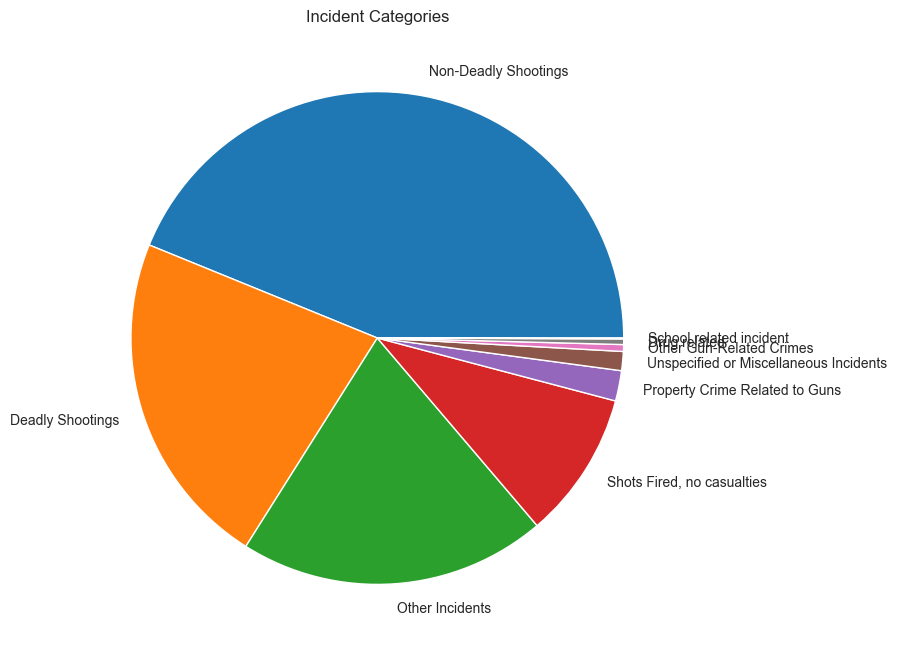

In [37]:
plt.figure(figsize=(10, 8))
plt.pie(incidents['incident_category'].value_counts(), labels=incidents['incident_category'].unique())
plt.title("Incident Categories")

In [38]:
# we can now drop the incident_characteristics1, incident_characteristics2 columns
incidents = incidents.drop(columns=['incident_characteristics1', 'incident_characteristics2'])

<Axes: >

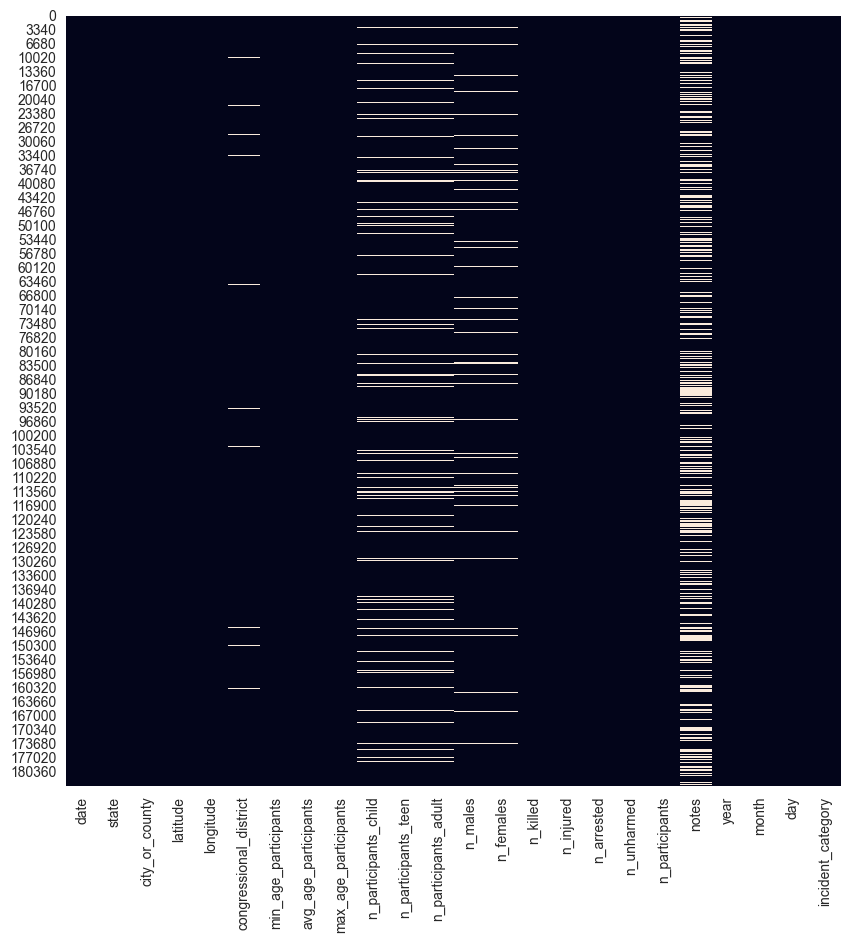

In [39]:
# heatmap of the null values
plt.figure(figsize=(10, 10))
sns.heatmap(incidents.isnull(), cbar=False)

# Feature Extraction
We extract the following features from the datasets:

- **kills_to_pov**: the ratio of people killed to the poverty percentage of the state in that year
- **age_to_average**: the ratio of average age of participants in each incident to the average age of participants in all incidents for that specific state
- **par_to_average**: the ratio of number of participants in each incident to the average number of participants in all incidents for that specific state
- **n_involved**: the number of participants involved in the incident
- **minors_to_pop**: the percentage of minors involved in the incident compared to total minors population in the state
- **par_to_pop**: the ratio between the number of participants and the population
- **kil_to_p**: the ratio of killed to total participants
- **man_to_p**: the ratio of male participants to total participants
- **fem_to_p**: the ratio of female participants to total participants
- **arr_to_p**: the ratio of arrested participants to total participants
- **unh_to_p**: the ratio of unharmed participants to total participants
- **inj_to_p**: the ratio of injured participants to total participants
- **num_minors**: the number of underaged participants in the incident
- **teen_to_m**: the ratio between the number of teen participants and the male participants
- **teen_to_f**: the ratio between the number of teen participants and the female participants 
- **par_to_tot**: the ratio of participants in each incident to the total number of participants in all incidents for that specific month and year

In [40]:
from feature_extractors import *

df = incidents
df2 = poverty
df3 = districts
df4 = population

In [41]:
df = crime_to_poverty(df, df2)
df = average_age(df)
df = average_participants(df)
df = involved(df)
df = minors_percentage(df, df4)
df = par_to_pop(df, df4)

In [42]:
df = ktp(df)
df = mtp(df)
df = ftp(df)
df = atp(df)
df = utp(df)
df = itp(df)

In [43]:
df = num_minors(df)
df = teen_to_m(df)
df = teen_to_f(df)
df = ratio_par_to_total(df)

In [44]:
df

,date,state,city_or_county,latitude,longitude,congressional_district,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,...,kil_to_p,man_to_p,fem_to_p,arr_to_p,unh_to_p,inj_to_p,n_minors,teen_to_m,teen_to_f,par_to_tot
0,2015-05-02,Indiana,Indianapolis,39.8322,-86.2492,7.0,19.0,19.0,19.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.009091
1,2017-04-03,Pennsylvania,Kane,41.6645,-78.7856,5.0,62.0,62.0,62.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003861
2,2016-11-05,Michigan,Detroit,42.4190,-83.0393,14.0,25.0,27.0,28.0,NaN,...,0.0,NaN,NaN,0.0,0.5,0.5,NaN,0.0,0.0,0.010638
3,2016-10-15,District of Columbia,Washington,38.9030,-76.9820,1.0,24.0,25.0,26.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.046512
4,2014-01-18,North Carolina,Wayne County,35.1847,-77.9527,13.0,65.0,65.0,65.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183649,2015-05-11,Maryland,Prince George,38.8869,-76.8981,4.0,34.0,34.0,34.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006369
183650,2016-01-11,Tennessee,Murfreesboro,35.8624,-86.3695,4.0,24.0,26.0,27.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004292
183651,2017-08-17,Tennessee,Memphis,35.1007,-89.9700,9.0,58.0,58.0,58.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.003968
183652,2016-06-07,Colorado,Colorado Springs,38.8251,-104.8020,5.0,68.0,68.0,68.0,0.0,...,0.0,1.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.020833


<Axes: >

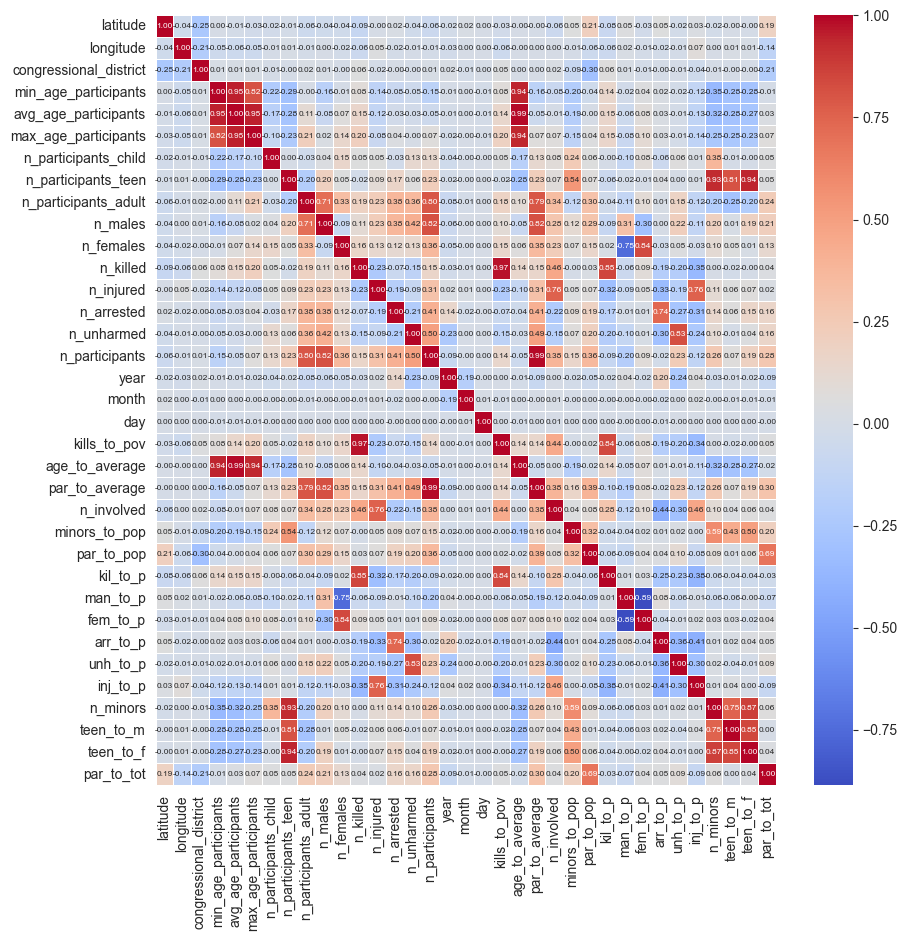

In [45]:
correlation_matrix = df.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 6})

In [46]:
# drop highly correlated features
df = df.drop(columns=['min_age_participants', 'max_age_participants'])  # highly correlated with avg_age_participants
df = df.drop(columns=['n_participants_teen', 'n_participants_child'])  # highly correlated with n_minors

In [47]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183654 entries, 0 to 183653
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date                    183654 non-null  object 
 1   state                   183654 non-null  object 
 2   city_or_county          183654 non-null  object 
 3   latitude                183654 non-null  float64
 4   longitude               183654 non-null  float64
 5   congressional_district  180373 non-null  float64
 6   avg_age_participants    183654 non-null  float64
 7   n_participants_adult    167019 non-null  float64
 8   n_males                 172462 non-null  float64
 9   n_females               172462 non-null  float64
 10  n_killed                183654 non-null  int64  
 11  n_injured               183654 non-null  int64  
 12  n_arrested              183654 non-null  int64  
 13  n_unharmed              183654 non-null  int64  
 14  n_participants      

<Axes: >

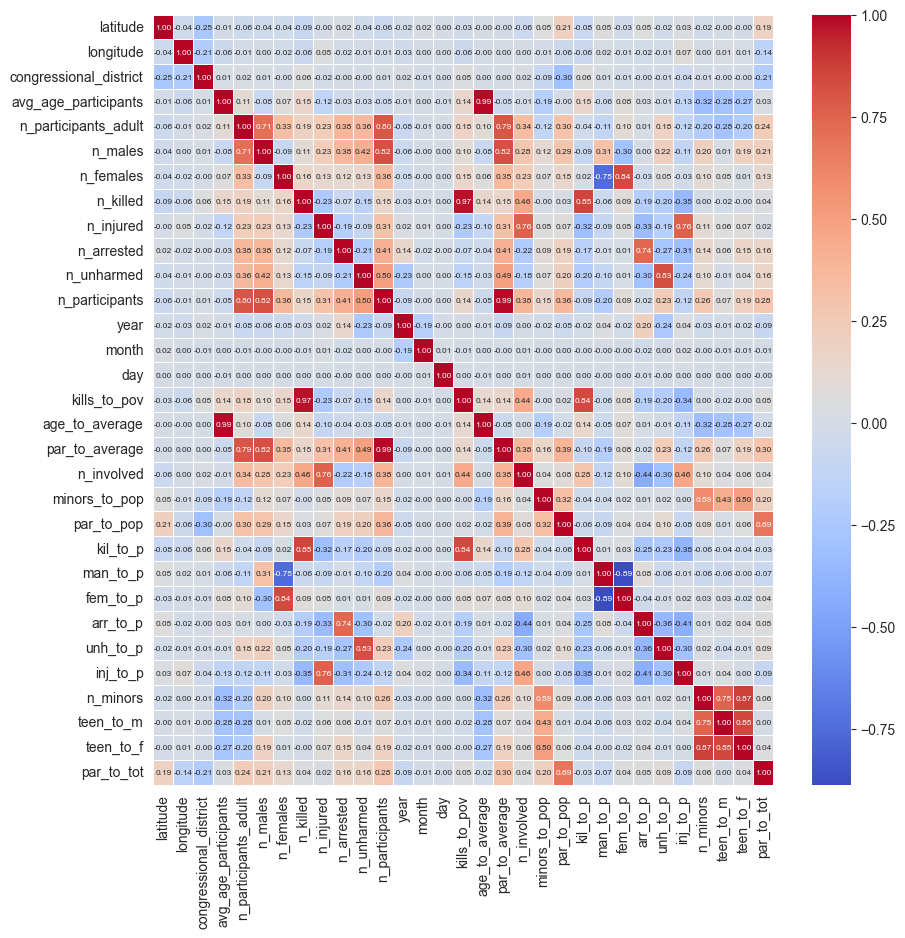

In [48]:
correlation_matrix = df.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 6})

<Axes: >

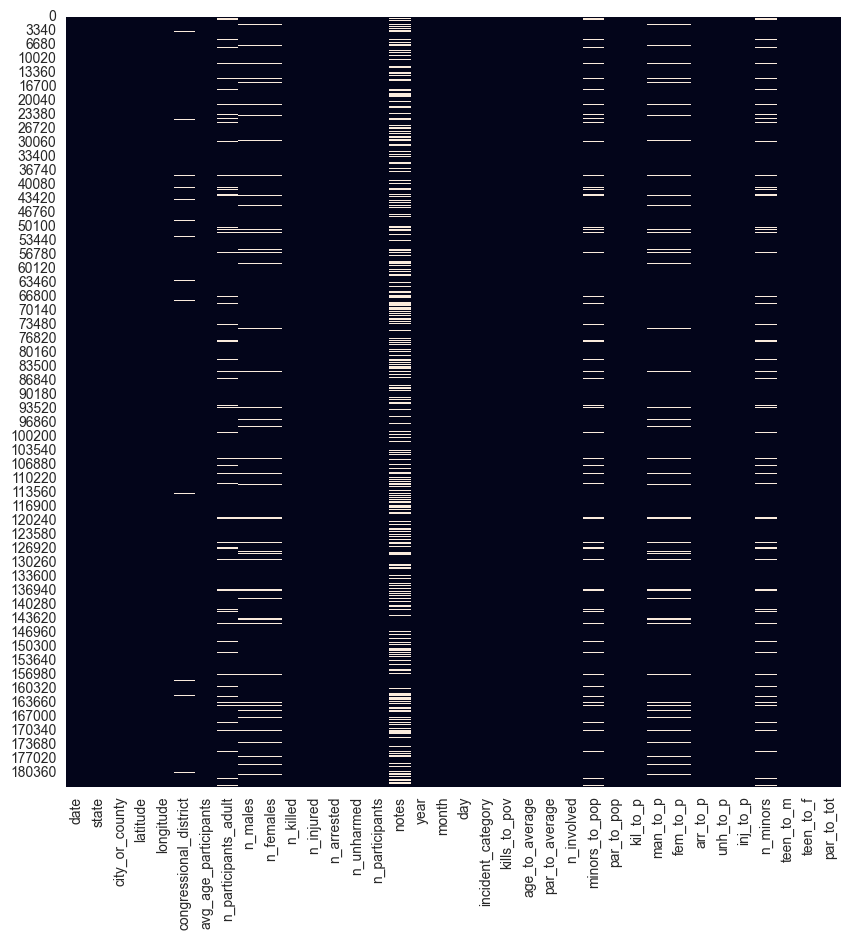

In [49]:
# heatmap of the null values
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(), cbar=False)

In [50]:
df.to_csv("../data/new_incidents.csv", index=False)